In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.utils import shuffle
import librosa as lb
from collections import Counter
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, AveragePooling1D, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load sound files as raw data
def load_data(data_dir, excel_file):
    data = [] # list of all raw audio array

    for i in range(excel_file.shape[0]): # loop to load all files with the given name mentioned in exel file
      aud = dir_wavfile+str(excel_file.iloc[i].values[0])+'.wav' #full path to heart wav file
      dt , sr = lb.load(aud, sr=2000) # dt : raw array and sr:sampling rate
      #print(aud)
      dt = lb.to_mono(dt) # convert to mono channel if it is double
      dt = dt.astype('float32')

      # # resampling frequecy rate into fix 2000 
      # number_of_samples = round(len(dt) * float(2000) / sr) # total samples in full signals
      # readings_resampled = signal.resample(dt, number_of_samples) # resample signal into calculated samples so getting 2000 sr. 

#       b, a = signal.butter(4, [0.02,0.5], 'bandpass', analog=False) # 4rt order banpass butterworth filter
#       readings_filtered = signal.filtfilt(b, a, dt) # apply filter to signal

      data.append([dt, excel_file.iloc[i].values[1]]) # append each signal into list as raw audio data

    return np.array(data)

In [3]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# geting data PCG sound samples
dir_wavfile = "/kaggle/input/d/sayedshahidhussain/physionet-chunked-data-of-8-sec/physionet_chunks_8sec_all/" # Physionet chunks of 8 sec
excel_file = pd.read_excel(dir_wavfile+"labels.xlsx", header=None)
raw_data= load_data(dir_wavfile, excel_file)

len(raw_data)

15231

In [5]:
# make Chunks all normal and abnormal
def data_extension(data):
  data_ext = [] # extended/trimmed data list of 10 sec equal chunks 
  y = [] # list of labels normal/abnormal
  input_length = 2000*8 # 8 seconds

  for i in range(0, len(data)): # loop through evey raw audio array
    if len(data[i][0]) > input_length: # if signal len is greater then 10 sec
      for t in range(0, len(data[i][0])-input_length, input_length):
        dx = data[i][0][t:t + input_length]
        data_ext.append(dx)
        y.append(data[i][1])
        temp2 = data[i][0][len(dx):]
        if len(temp2)<=input_length: # and len(temp2)>=9*8000:
          dx = temp2
          while (input_length>len(dx)):                                          # if signal len is less then 10 sec 
            dif = abs(input_length - len(dx))     # get require extended len 
            req_padd = dx[:dif]
            dx = np.append(dx, req_padd, axis=0)
      
    elif len(data[i][0] < input_length): 
      dx = data[i][0]
      while (input_length>len(dx)):                                          # if signal len is less then 10 sec 
        dif = abs(input_length - len(dx))     # get require extended len 
        req_padd = dx[:dif]
        dx = np.append(dx, req_padd, axis=0)
        # for s in req_padd:
        #   dx.append(s)
    
    else:
      dx = data[i][0]
    
      
    data_ext.append(dx) # append extended/trimmed data to list
    y.append(data[i][1]) # append the label to label list

  return data_ext, y

In [6]:
# Preprocessing
X, y = data_extension(raw_data)
X = preprocessing.scale(X)
y[:] = [0 if i==-1 else i for i in y]

X, y = shuffle(X, y)
X, y = shuffle(X, y)

#print(y[0:25])
print("X_length:",len(X))
print("y_length:",len(y))

X = np.asarray(X)
y = np.asarray(y)
print("y_labels_count:",Counter(y))

X_length: 15231
y_length: 15231
y_labels_count: Counter({0: 8076, 1: 7155})


In [7]:
# get train, validation, test splits
# train_Val_test split
def split_data(test_size, validation_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    
X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(0.15, 0.15)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.12)
print("Train set:",X_train.shape)
print("Test set:",X_test.shape)
print("Validation set:",X_validation.shape)

Train set: (11004, 16000)
Test set: (2285, 16000)
Validation set: (1942, 16000)


In [8]:
# Reshaping data for 1D conv model
X_train = X_train.reshape(11004,16000,1) 
X_test = X_test.reshape(2285,16000,1)
X_validation = X_validation.reshape(1942,16000,1)
print("Train set:",X_train.shape)
print("Test set:",X_test.shape)
print("Validation set:",X_validation.shape)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_validation = to_categorical(y_validation, 2)

Train set: (11004, 16000, 1)
Test set: (2285, 16000, 1)
Validation set: (1942, 16000, 1)


In [9]:
def Conv_model(X_train):

    x_input = Input(shape =(X_train.shape[1], X_train.shape[2]))

    conv0 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x_input) #, kernel_regularizer=l2(0.001)
    D0=Dropout(0.25)(conv0)
    pool0 = MaxPooling1D(pool_size=2,padding='same')(D0)

    conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(pool0)
    D1=Dropout(0.25)(conv1)
    pool1 = MaxPooling1D(pool_size=2,padding='same')(D1)

    conv2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    D2=Dropout(0.25)(conv2)
    pool2 = MaxPooling1D(pool_size=2,padding='same')(D2)

    conv3 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    D3=Dropout(0.25)(conv3)
    pool3 = MaxPooling1D(pool_size=2,padding='same')(D3)

    conv4 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(pool3)
    D4=Dropout(0.25)(conv4)
    pool4 = MaxPooling1D(pool_size=2,padding='same')(D4)

    conv5 = Conv1D(16, kernel_size=3, activation='relu', padding='same')(pool4)
    D5=Dropout(0.25)(conv5)
    pool5 = MaxPooling1D(pool_size=2,padding='same')(D5)

    flat1 = Flatten()(pool5)
    D6=Dropout(0.25)(flat1)

    output = Dense(2, activation = 'softmax')(D6) #softmax
    model = Model(inputs=x_input, outputs=output)
    
    return model

In [10]:
model = Conv_model(X_train)
#model.summary()
# compile model
optimiser = Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=16, validation_data=(X_validation, y_validation), epochs=120)

Epoch 1/120
688/688 [==============================] - 56s 67ms/step - loss: 0.5813 - accuracy: 0.6938 - val_loss: 0.5347 - val_accuracy: 0.7976
Epoch 2/120
688/688 [==============================] - 46s 67ms/step - loss: 0.4186 - accuracy: 0.8130 - val_loss: 0.4495 - val_accuracy: 0.8368
Epoch 3/120
688/688 [==============================] - 47s 68ms/step - loss: 0.3657 - accuracy: 0.8406 - val_loss: 0.4157 - val_accuracy: 0.8301
Epoch 4/120
688/688 [==============================] - 47s 68ms/step - loss: 0.3440 - accuracy: 0.8487 - val_loss: 0.3845 - val_accuracy: 0.8507
Epoch 5/120
688/688 [==============================] - 47s 68ms/step - loss: 0.3293 - accuracy: 0.8590 - val_loss: 0.3671 - val_accuracy: 0.8553
Epoch 6/120
688/688 [==============================] - 47s 68ms/step - loss: 0.3172 - accuracy: 0.8655 - val_loss: 0.3566 - val_accuracy: 0.8563
Epoch 7/120
688/688 [==============================] - 47s 68ms/step - loss: 0.3041 - accuracy: 0.8704 - val_loss: 0.3554 - val_ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



688/688 [==============================] - 46s 68ms/step - loss: 0.1495 - accuracy: 0.9435 - val_loss: 0.2214 - val_accuracy: 0.9140
Epoch 81/120
688/688 [==============================] - 46s 68ms/step - loss: 0.1433 - accuracy: 0.9457 - val_loss: 0.2156 - val_accuracy: 0.9192
Epoch 82/120
688/688 [==============================] - 46s 67ms/step - loss: 0.1460 - accuracy: 0.9457 - val_loss: 0.2309 - val_accuracy: 0.9109
Epoch 83/120
688/688 [==============================] - 46s 68ms/step - loss: 0.1412 - accuracy: 0.9479 - val_loss: 0.2347 - val_accuracy: 0.9078
Epoch 84/120
688/688 [==============================] - 46s 67ms/step - loss: 0.1436 - accuracy: 0.9485 - val_loss: 0.2555 - val_accuracy: 0.9053
Epoch 85/120
 26/688 [>.............................] - ETA: 42s - loss: 0.1325 - accuracy: 0.9543

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



688/688 [==============================] - 46s 67ms/step - loss: 0.1429 - accuracy: 0.9477 - val_loss: 0.2098 - val_accuracy: 0.9171
Epoch 90/120
688/688 [==============================] - 46s 67ms/step - loss: 0.1371 - accuracy: 0.9476 - val_loss: 0.2191 - val_accuracy: 0.9176
Epoch 91/120
688/688 [==============================] - 46s 67ms/step - loss: 0.1384 - accuracy: 0.9490 - val_loss: 0.2143 - val_accuracy: 0.9202
Epoch 92/120
688/688 [==============================] - 46s 67ms/step - loss: 0.1386 - accuracy: 0.9485 - val_loss: 0.2161 - val_accuracy: 0.9207
Epoch 93/120
297/688 [===========>..................] - ETA: 24s - loss: 0.1357 - accuracy: 0.9501

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



688/688 [==============================] - 46s 68ms/step - loss: 0.1310 - accuracy: 0.9503 - val_loss: 0.2273 - val_accuracy: 0.9150
Epoch 102/120
688/688 [==============================] - 47s 68ms/step - loss: 0.1309 - accuracy: 0.9522 - val_loss: 0.2075 - val_accuracy: 0.9222
Epoch 103/120
688/688 [==============================] - 46s 68ms/step - loss: 0.1350 - accuracy: 0.9503 - val_loss: 0.2156 - val_accuracy: 0.9130
Epoch 104/120
688/688 [==============================] - 46s 68ms/step - loss: 0.1278 - accuracy: 0.9539 - val_loss: 0.2062 - val_accuracy: 0.9243
Epoch 105/120
688/688 [==============================] - 47s 68ms/step - loss: 0.1268 - accuracy: 0.9515 - val_loss: 0.2129 - val_accuracy: 0.9212
Epoch 106/120
688/688 [==============================] - 47s 68ms/step - loss: 0.1301 - accuracy: 0.9522 - val_loss: 0.2133 - val_accuracy: 0.9145
Epoch 107/120
688/688 [==============================] - 47s 68ms/step - loss: 0.1267 - accuracy: 0.9528 - val_loss: 0.2356 - val_ac

In [12]:
#save model
model.save(r'/kaggle/working/cnn1D_physionet_8sec.h5')
model.save_weights(r'/kaggle/working/cnn1D_weights_physionet_8sec.h5')

In [13]:
#tensorflow lite
import tensorflow as tf
from keras.models import load_model
from sys import getsizeof
model = load_model('/kaggle/input/trained-model/cnn1D_physionet_8sec.h5')

tf_lite_model_file_name = "pcg_physionet.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
open(tf_lite_model_file_name, "wb").write(tflite_model)

420568

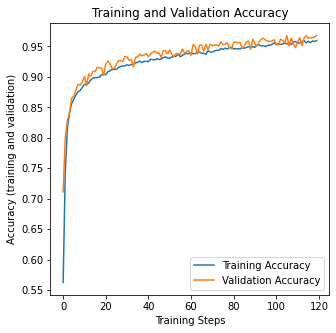

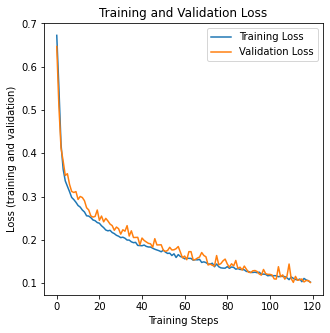

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(120)

#plt.subplot(2, 2, 1)
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.savefig("/kaggle/working/Accuracy_plot", bbox_inches='tight')
plt.show()

#plt.subplot(2, 2, 2)
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

plt.savefig("/kaggle/working/Loss_plot", bbox_inches='tight')
plt.show()

In [30]:
def evaluation_metrics(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    precision = round(precision_score(y_true, y_pred,average='weighted') * 100, 2)
    f1Score = round(f1_score(y_true, y_pred, average='weighted') * 100, 2) 
    target_names=['Abnormal','Normal']
    cm=confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv= tp / (tp+fp)
    npr= tn / (tn+fn)

    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("\nconfusion_matrix")
    print(cm)
    print("\nTrue Negative  : {}".format(tn))
    print("Flase Positive  : {}".format(fp))
    print("False Negative  : {}".format(fn))
    print("True Positive  : {}".format(tp))
    print("\nSpecificity  : {}".format(specificity))
    print("Sensitivity  : {}".format(sensitivity))
    print("Positive predictive value (PPV): {}".format(ppv))
    print("Negative predictive value (NPV)  : {}".format(npr))
  
    return accuracy, precision, f1Score, cm

In [31]:
# Validation
validation_data_cnn = (X_validation, y_validation)
predictions_cnn_validation = model.predict(X_validation, verbose=1)
yPredictions_cnn_validation = np.argmax(predictions_cnn_validation, axis=1)
true_classes_cnn_validation=np.argmax(y_validation, axis=1)
print("Validation data:")    
valAcc, valPrec, valFScore,valcm = evaluation_metrics(true_classes_cnn_validation, yPredictions_cnn_validation)

61/61 [==============================] - 0s 3ms/step
Validation data:
Accuracy  : 96.81
Precision : 96.89
f1Score : 96.81

confusion_matrix
[[976  50]
 [ 12 904]]

True Negative  : 976
Flase Positive  : 50
False Negative  : 12
True Positive  : 904

Specificity  : 0.9512670565302144
Sensitivity  : 0.9868995633187773
Positive predictive value (PPV): 0.9475890985324947
Negative predictive value (NPV)  : 0.9878542510121457


In [32]:
# Test Data
test_data_cnn = (X_test, y_test)
predictions_cnn_test = model.predict(X_test, verbose=1)
yPredictions_cnn_test = np.argmax(predictions_cnn_test, axis=1)
true_classes_cnn_test=np.argmax(y_test, axis=1)
print("Test data:")    
testAcc, testPrec, testFScore,testcm = evaluation_metrics(true_classes_cnn_test, yPredictions_cnn_test)

72/72 [==============================] - 0s 3ms/step
Test data:
Accuracy  : 95.45
Precision : 95.54
f1Score : 95.45

confusion_matrix
[[1112   76]
 [  28 1069]]

True Negative  : 1112
Flase Positive  : 76
False Negative  : 28
True Positive  : 1069

Specificity  : 0.936026936026936
Sensitivity  : 0.9744758432087511
Positive predictive value (PPV): 0.9336244541484716
Negative predictive value (NPV)  : 0.9754385964912281
